In [1]:
# Subword level similarities

In [24]:
from crawled_data import CrawledData
from collections import Counter
from itertools import combinations
import pandas as pd
import math
import json
import string
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import entropy

In [6]:
# Read data

In [7]:
data_obj = CrawledData()
data_obj.read_crawled_data("../data/crawled/folksongs/", remove_punctuation = True)
print(data_obj.data.keys())
data_obj.read_crawled_data("../data/crawled/poetry/", remove_punctuation = True)
print(data_obj.data.keys())
acc_data = dict()
for lang in data_obj.data:
    acc_data[lang] = " ".join([data_obj.data[lang][file_id]["text"] for file_id in data_obj.data[lang]])


Getting files for rajasthani
Getting files for gujarati
Getting files for himachali
Getting files for hindi-urdu
Getting files for magahi
Getting files for awadhi
Getting files for punjabi
Getting files for koraku
Getting files for baiga
Getting files for .DS_Store
Getting files for nimaadi
Getting files for khadi_boli
Getting files for bhojpuri
Getting files for garwali
Getting files for chattisgarhi
Getting files for brajbhasha
Getting files for bhil
Getting files for sanskrit
Getting files for angika
Getting files for hariyanvi
Getting files for kannauji
Getting files for bundeli
Getting files for bangla
Getting files for malwi
Getting files for marathi
Getting files for kumaoni
Getting files for bhadavari
dict_keys(['rajasthani', 'gujarati', 'himachali', 'hindi-urdu', 'magahi', 'awadhi', 'punjabi', 'koraku', 'baiga', 'nimaadi', 'khadi_boli', 'bhojpuri', 'garwali', 'chattisgarhi', 'brajbhasha', 'bhil', 'sanskrit', 'angika', 'hariyanvi', 'kannauji', 'bundeli', 'bangla', 'malwi', 'mar

In [51]:
langs = [
"sindhi",
"rajasthani",
"punjabi",
"hariyanvi",
#"gujarati",
"khadi_boli",
#"sanskrit",
"hindi-urdu",
"bhil",
"koraku",
"baiga",
"nimaadi",
"malwi",
"marathi",
"bhadavari",
"himachali",
"garwali",
"kumaoni",
"kannauji",
"brajbhasha",
"bundeli",
"awadhi",
"chattisgarhi",
"nepali",
#"pali",
"bhojpuri",
"bajjika",
"magahi",
"maithili",
"angika",
#"bangla"
        ]

north = ["sindhi", "punjabi", "hariyanvi", "bhadavari", "himachali", "garwali", "kumaoni", "kannauji", "nepali"]
north_central = ["sindhi", "rajasthani", "punjabi", "hariyanvi", "hindi-urdu", "khadi_boli", "kannauji", "brajbhasha", "bundeli", \
                "awadhi", "chattisgarhi", "bhojpuri", "bajjika", "magahi", "maithili", "angika"]
central = ["rajasthani", "hindi-urdu", "gujarati", "bhil", "koraku", "baiga", "nimaadi", "malwi", "marathi", "chattisgarhi"]

# langs = [lang for lang in langs if lang in north_central]

for idx, lang in enumerate(langs):
    print(idx, lang)

0 sindhi
1 rajasthani
2 punjabi
3 hariyanvi
4 khadi_boli
5 hindi-urdu
6 bhil
7 koraku
8 baiga
9 nimaadi
10 malwi
11 marathi
12 bhadavari
13 himachali
14 garwali
15 kumaoni
16 kannauji
17 brajbhasha
18 bundeli
19 awadhi
20 chattisgarhi
21 nepali
22 bhojpuri
23 bajjika
24 magahi
25 maithili
26 angika


In [9]:
# remove_langs = ["gujarati", "pali", "sanskrit", "bangla"]
# langs = [lang for lang in data_obj.data.keys() if lang not in remove_langs]

In [11]:
len(langs)

29

In [2]:
#Get frequency dist of i-chargrams of a single language

In [52]:
def get_i_chargram_freq(text, i):
    
    i_cg_set = Counter()
    text = "".join([c for c in text if c not in [" ", "\n", "\t"]])
    
    for idx, c in enumerate(text):
        if idx + i <= len(text):
            i_cg_set[text[idx:idx+i]] += 1
            
    return i_cg_set
    
    

In [53]:
#Get freq dist of i-chargrams of all languages
lang_cgrams = dict()
cgram_range = range(2,5)

for window in cgram_range:
    lang_cgrams[window] = dict()
    for lang in langs:
        lang_cgrams[window][lang] = get_i_chargram_freq(acc_data[lang], window)




In [54]:
# totals = {window: sum([lang_cgrams[window][lang].keys() for lang in langs]) for window in cgram_range}
totals = {window: len({cgram for lang in langs for cgram in lang_cgrams[window][lang]}) for window in cgram_range}

In [55]:
total

{2: 12028, 3: 201942, 4: 1562278}

In [56]:
def find_shared_cgrams(langs, lang_cgrams, window, kl = False):
    '''Calculate either cgram similarity or Kullback-Leibler divergence'''
    N = len(langs)    
    shared_lex_metrics = [[0]*N for _ in range(N)]

    for i, j in combinations(range(N), 2):
        l_1, l_2 = langs[i], langs[j]
        lex_l_1, lex_l_2 = set(lang_cgrams[window][l_1].keys()), set(lang_cgrams[window][l_2].keys())
        shared_lex = list(lex_l_1.intersection(lex_l_2))
        if kl:
            l_1_dist = [lang_cgrams[window][l_1][cgram] for cgram in shared_lex]
            l_2_dist = [lang_cgrams[window][l_2][cgram] for cgram in shared_lex]
            klp = (entropy(pk = l_1_dist, qk = l_2_dist) + entropy(pk = l_2_dist, qk = l_1_dist))/2
            shared_lex_metrics[i][j] = klp 
            shared_lex_metrics[j][i] = klp
            
        else:
            shared_lex_metrics[i][j] = len(shared_lex)
            shared_lex_metrics[j][i] = len(shared_lex)

    shared_lex_metrics = np.asarray(shared_lex_metrics)

    for i in range(N):
        if kl:
            shared_lex_metrics[i][i] = 0
        else:
            shared_lex_metrics[i][i] = 1
#         shared_lex_dict[langs[i]][langs[i]] = 1
    
    return shared_lex_metrics

In [63]:
# Cgram similarity
N = len(langs)    
find_range = range(2,3)
shared_cgram_total = np.zeros((N,N))
for window in find_range:
    shared_cgram_total += find_shared_cgrams(langs, lang_cgrams, window, kl = False)

normalization = sum([totals[window] for window in find_range])
print(normalization)
shared_cgram_total = shared_cgram_total/normalization

11969


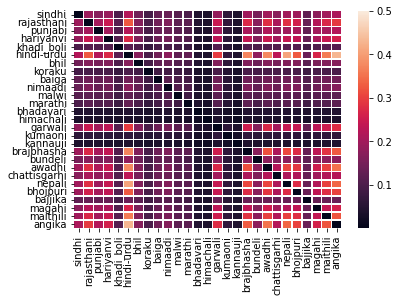

In [60]:
ax = sns.heatmap(shared_cgram_total, linewidth=0.3, mask = shared_cgram_total == 1, vmax = 0.5, xticklabels=langs, yticklabels=langs)#, annot=True, annot_kws={"size":6})
fig = ax.get_figure()
# fig.savefig("stats_outputs/lexical_similarity/north_central.png")

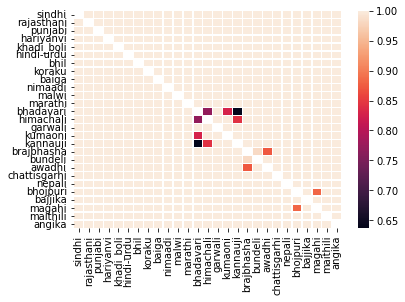

In [65]:
# KL Divergence
N = len(langs)    
find_range = range(3,5)
klp_total = np.zeros((N,N))
for window in find_range:
    klp_total += find_shared_cgrams(langs, lang_cgrams, window, kl = True)



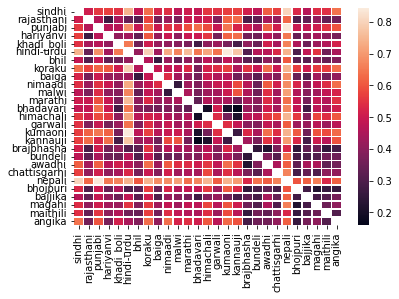

In [71]:
klp_total = klp_total/2
ax = sns.heatmap(klp_total, linewidth=0.3, mask = klp_total == 0, xticklabels=langs, yticklabels=langs)#, annot=True, annot_kws={"size":6})
fig = ax.get_figure()

In [70]:
klp_total[0,1]

1.0155788635877205